In [1]:
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

def compute_Ichimoku_on_DataFrame(df: pd.DataFrame):
    # Compute rolling max/min for the necessary periods
    highest_9 = df['high'].rolling(window=9).max()
    lowest_9 = df['low'].rolling(window=9).min()

    highest_26 = df['high'].rolling(window=26).max()
    lowest_26 = df['low'].rolling(window=26).min()

    highest_52 = df['high'].rolling(window=52).max()
    lowest_52 = df['low'].rolling(window=52).min()

    # Compute Ichimoku components
    df['tenkan'] = (highest_9 + lowest_9) / 2
    df['kijun'] = (highest_26 + lowest_26) / 2
    df['ssa'] = (df['tenkan'] + df['kijun']) / 2
    df['ssb'] = (highest_52 + lowest_52) / 2

    # Shift the "ssa" and "ssb" values to align them properly
    df['ssa'] = df['ssa'].shift(26)
    df['ssb'] = df['ssb'].shift(26)
    
    return df

path = "C:/Users/tessa/MotiveWave Data/"

### M5 ###
df_M5 = pd.read_csv(
    filepath_or_buffer=path+"@MES.CME.TOP_STEP_5.csv",
    names=["datetime", "open", "high", "low","close", "volume"],
    header=None,
    delimiter=","
)
df_M5['datetime'] = pd.to_datetime(df_M5['datetime'], format='%d/%m/%Y %H:%M:%S')
df_M5 = compute_Ichimoku_on_DataFrame(df_M5)

### M15 ###
df_M15 = pd.read_csv(
    filepath_or_buffer=path+"@MES.CME.TOP_STEP_15.csv",
    names=["datetime", "open", "high", "low","close", "volume"],
    header=None,
    delimiter=","
)
df_M15['datetime'] = pd.to_datetime(df_M15['datetime'], format='%d/%m/%Y %H:%M:%S')
df_M15 = compute_Ichimoku_on_DataFrame(df_M15)

### H1 ###
df_H1 = pd.read_csv(
    filepath_or_buffer=path+"@MES.CME.TOP_STEP_60.csv",
    names=["datetime", "open", "high", "low","close", "volume"],
    header=None,
    delimiter=","
)
df_H1['datetime'] = pd.to_datetime(df_H1['datetime'], format='%d/%m/%Y %H:%M:%S')
df_H1 = compute_Ichimoku_on_DataFrame(df_H1)


### ADD SSA AND SSB DATA FROM M15 AND H1 ###
df_M5 = pd.merge(df_M5, df_M15[['datetime', 'ssa', 'ssb']], on='datetime', how='left', suffixes = ["", "_m15"])
df_M5["ssa_m15"] = df_M5["ssa_m15"].ffill()
df_M5["ssb_m15"] = df_M5["ssb_m15"].ffill()

df_M5 = pd.merge(df_M5, df_H1[['datetime', 'ssa', 'ssb']], on='datetime', how='left', suffixes = ["", "_h1"])
df_M5["ssa_h1"] = df_M5["ssa_h1"].ffill()
df_M5["ssb_h1"] = df_M5["ssb_h1"].ffill()

del df_M15
del df_H1

# 1. Convertir la colonne datetime en index pour faciliter la resampling des données journalières
df_M5.set_index('datetime', inplace=True)

# 2. Calculer les prix journaliers : High, Low et Close (resampling daily)
df_daily = df_M5.resample('D').agg({'high': 'max', 'low': 'min', 'close': 'last'})

# 3. Calculer les niveaux de point pivot (PP, R3, R2, R1, S1, S2, S3)
df_daily['PP'] = (df_daily['high'] + df_daily['low'] + df_daily['close']) / 3
df_daily['R1'] = (2 * df_daily['PP']) - df_daily['low']
df_daily['R2'] = df_daily['PP'] + (df_daily['high'] - df_daily['low'])
df_daily['R3'] = df_daily['high'] + 2 * (df_daily['PP'] - df_daily['low'])
df_daily['S1'] = (2 * df_daily['PP']) - df_daily['high']
df_daily['S2'] = df_daily['PP'] - (df_daily['high'] - df_daily['low'])
df_daily['S3'] = df_daily['low'] - 2 * (df_daily['high'] - df_daily['PP'])

# 4. Fusionner ces points pivots journaliers dans le dataframe 5min
# On va faire un merge sur l'index (qui est 'datetime' après resampling)
df_M5 = df_M5.merge(df_daily[['PP', 'R1', 'R2', 'R3', 'S1', 'S2', 'S3']], 
                     left_index=True, right_index=True, how='left')

# 5. Optionnel : remplir les valeurs manquantes si nécessaire (avec ffill ou bfill)
df_M5[['PP', 'R1', 'R2', 'R3', 'S1', 'S2', 'S3']] = df_M5[['PP', 'R1', 'R2', 'R3', 'S1', 'S2', 'S3']].ffill()

# Affichage du DataFrame mis à jour
df_M5.dropna(inplace=True)
df_M5.reset_index(inplace=True)

del df_daily

df_M5


,datetime,open,high,low,close,volume,tenkan,kijun,ssa,ssb,...,ssb_m15,ssa_h1,ssb_h1,PP,R1,R2,R3,S1,S2,S3
0,2019-08-08 08:00:00,2894.00,2894.25,2890.75,2891.25,460,2892.875,2892.375,2888.7500,2882.375,...,2857.125,2854.2500,2854.750,2916.916667,2963.333333,2987.916667,3034.333333,2892.333333,2845.916667,2821.333333
1,2019-08-08 08:05:00,2891.25,2893.25,2890.50,2892.50,242,2892.750,2892.375,2888.7500,2882.375,...,2857.125,2854.2500,2854.750,2916.916667,2963.333333,2987.916667,3034.333333,2892.333333,2845.916667,2821.333333
2,2019-08-08 08:10:00,2892.50,2894.25,2891.75,2893.75,248,2892.750,2892.375,2889.0000,2882.375,...,2857.125,2854.2500,2854.750,2916.916667,2963.333333,2987.916667,3034.333333,2892.333333,2845.916667,2821.333333
3,2019-08-08 08:15:00,2894.00,2894.00,2893.25,2893.25,251,2892.625,2892.375,2889.1875,2882.375,...,2857.125,2854.2500,2854.750,2916.916667,2963.333333,2987.916667,3034.333333,2892.333333,2845.916667,2821.333333
4,2019-08-08 08:20:00,2893.50,2896.50,2893.50,2896.25,489,2893.500,2893.125,2889.6875,2882.375,...,2857.125,2854.2500,2854.750,2916.916667,2963.333333,2987.916667,3034.333333,2892.333333,2845.916667,2821.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361678,2025-02-14 13:00:00,6124.75,6127.00,6124.50,6125.75,2076,6124.125,6128.250,6137.6250,6139.625,...,6116.500,6066.1875,6059.625,6131.666667,6142.083333,6157.416667,6167.833333,6116.333333,6105.916667,6090.583333
361679,2025-02-14 13:05:00,6125.50,6125.75,6124.25,6125.25,693,6124.125,6128.000,6137.5000,6139.625,...,6116.500,6066.1875,6059.625,6131.666667,6142.083333,6157.416667,6167.833333,6116.333333,6105.916667,6090.583333
361680,2025-02-14 13:10:00,6125.25,6127.25,6125.00,6126.75,1305,6124.250,6127.500,6137.4375,6139.625,...,6116.500,6066.1875,6059.625,6131.666667,6142.083333,6157.416667,6167.833333,6116.333333,6105.916667,6090.583333
361681,2025-02-14 13:15:00,6126.75,6128.00,6126.25,6127.00,1292,6124.625,6127.375,6137.1875,6139.625,...,6116.500,6066.1875,6059.625,6131.666667,6142.083333,6157.416667,6167.833333,6116.333333,6105.916667,6090.583333


In [ ]:
import strategy_runner
from strategies.DTP_Strategy import DTP
from datetime import datetime
pd.options.mode.chained_assignment = None  # default='warn'

trades_database = {}

params = {
    "stopMethods": [2], # [1, 2],
    "slInTicks": [25,50,75,100],
    "tpInTicks": [25,50,75,100],
    "onlyUSSession": [True, False]
}
use3UT = False
useAllEntryPoints = False

strategy = DTP(df_M5[:350_000], use3UT, useAllEntryPoints)
iteration = 1
for sm in params["stopMethods"]:
    for sl in params["slInTicks"]:
        for tp in params["tpInTicks"]:
            for onlyUSSession in params["onlyUSSession"]:
                if tp/sl < 1.6: # On ne veut que des trade avec un risk ratio >= à 1
                    start_time = datetime.now()
                    print(f'parameters: sl={sl}, tp={tp}, US_hours_only={onlyUSSession}, sm={sm} are being tested...')
                    trades = strategy_runner.strategyLoop(strategy, sl, tp, onlyUSSession, stopMethod=sm)
                    trades_database[iteration] = [trades, sl, tp, onlyUSSession, sm]
                    end_time = datetime.now()
                    print(f'iteration n°{iteration} finished in {end_time-start_time}')
                    iteration+=1


parameters: sl=25, tp=25, US_hours_only=True, sm=1 are being tested...
iteration n°1 finished in 0:01:44.122777
parameters: sl=25, tp=25, US_hours_only=False, sm=1 are being tested...
iteration n°2 finished in 0:03:50.462285
parameters: sl=50, tp=25, US_hours_only=True, sm=1 are being tested...
iteration n°3 finished in 0:01:43.111891
parameters: sl=50, tp=25, US_hours_only=False, sm=1 are being tested...
iteration n°4 finished in 0:03:50.326707
parameters: sl=50, tp=50, US_hours_only=True, sm=1 are being tested...
iteration n°5 finished in 0:01:46.403168
parameters: sl=50, tp=50, US_hours_only=False, sm=1 are being tested...
iteration n°6 finished in 0:03:52.485897
parameters: sl=50, tp=75, US_hours_only=True, sm=1 are being tested...
iteration n°7 finished in 0:01:45.348838
parameters: sl=50, tp=75, US_hours_only=False, sm=1 are being tested...
iteration n°8 finished in 0:03:52.316746
parameters: sl=75, tp=25, US_hours_only=True, sm=1 are being tested...
iteration n°9 finished in 0:0

In [3]:
### SAVE THE DATA ###
import pickle 
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

### LOAD THE DATA ###
def load_object(filename):
    with open(filename, 'rb') as input: 
        return pickle.load(input)

In [4]:
save_object(trades_database, 'trade_datas/basicEntries_3UT_levels_breakeven=0_StrategyStop1&2.pkl')

In [12]:
trades_database = load_object('trade_datas/basicEntries_3UT_levels_breakeven=0_StrategyStop1&2.pkl')
# BEST WINRATE SO FAR : trades_database_basic_no_3UT_levels.pkl with 0.5813

In [16]:
import pandas as pd

def sort_by_winrate(item):
    _, dict_values = item
    return dict_values['winrate (%)']

def sort_by_total_pnl(item):
    _, dict_values = item
    return dict_values['total_pnl_from_start (%)']


def create_winrate_dictionnary(trades_database, sort_option):
    winrate_dictionnary = {}

    for id, trade_data in trades_database.items():
        df, sl, tp, onlyUSSession, sm = trade_data

        loser_entry_price = df.loc[df['profit_from_start(%)']<=0, 'entry_price']
        loser_exit_price = df.loc[df['profit_from_start(%)']<=0, 'exit_price']
        avg_real_sl_executed = abs(loser_entry_price-loser_exit_price).mean()

        wins = df.loc[df['profit_from_start(%)']>=0, 'position'].count()
        loss = df.loc[df['profit_from_start(%)']<0, 'position'].count()
        winrate = 0.0 if loss+wins == 0.0 else 100*wins/(loss+wins)
        breakevens = df.loc[df['profit_from_start(%)']==0, 'position'].count()
        avg_gain_from_start = df.loc[df['profit_from_start(%)']>=0, 'profit_from_start(%)'].mean()
        avg_loss_from_start = df.loc[df['profit_from_start(%)']<0, 'profit_from_start(%)'].mean()
        # median_times_below_breakeven = df['times_below_breakeven'].median()
        total_pnl_from_start = df['profit_from_start(%)'].sum()
        quantiles_duration = (df["exit_date"]-df["entry_date"]).quantile([0.50,0.75])

        winrate_dictionnary[id] = {
            'winrate (%)': round(winrate, 3), 
            'risk_ratio': round(tp/sl, 2), 
            "total_pnl_from_start (%)": round(total_pnl_from_start, 2),
            "avg_gain_from_start (%)": round(avg_gain_from_start, 2),
            "avg_loss_from_start (%)": round(avg_loss_from_start,2),
            "median duration": quantiles_duration.loc[0.50], 
            "75percent duration": quantiles_duration.loc[0.75],
            "avg_real_sl_executed":avg_real_sl_executed,
            'TP/SL (Ticks)': (tp, sl),
            'nbr wins/loss/breakeven' : (wins, loss, breakevens),
            "stop_method": sm,
            # "median_times_below_breakeven": round(median_times_below_breakeven,2),
            'US_session_only' : onlyUSSession,
            #'nbr_of_trades': wins.item()+loss.item(), 
        }
    if sort_option == 1:
        winrate_dictionnary = dict(sorted(winrate_dictionnary.items(), key=sort_by_winrate))
    elif sort_option == 2:
        winrate_dictionnary = dict(sorted(winrate_dictionnary.items(), key=sort_by_total_pnl))
        
    return winrate_dictionnary

In [58]:
trades_sample, _, _, _ = trades_database[1]
print(f"start date : {trades_sample.iloc[0]["entry_date"]}, end date : {trades_sample.iloc[-1]["entry_date"]}")

start date : 2019-08-13 18:10:00, end date : 2022-02-09 18:35:00


In [17]:
print('basicEntries_3UT_levels_breakeven=0_StrategyStop1&2')
trades_database = load_object('trade_datas/basicEntries_3UT_levels_breakeven=0_StrategyStop1&2.pkl')
winrate_dictionnary = create_winrate_dictionnary(trades_database, 2)
pd.DataFrame.from_dict(winrate_dictionnary, orient='index')

basicEntries_3UT_levels_breakeven=0_StrategyStop1&2


,winrate (%),risk_ratio,total_pnl_from_start (%),avg_gain_from_start (%),avg_loss_from_start (%),median duration,75percent duration,avg_real_sl_executed,TP/SL (Ticks),nbr wins/loss/breakeven,stop_method,US_session_only
1,46.541,1.00,6.57,0.18,-0.13,0 days 00:25:00,0 days 00:45:00,7.213035,"(25, 25)","(222, 255, 2)",1,True
15,41.414,1.33,7.54,0.28,-0.13,0 days 01:15:00,0 days 02:25:00,10.750000,"(100, 75)","(82, 116, 1)",1,True
25,44.835,1.00,8.55,0.19,-0.12,0 days 00:25:00,0 days 00:45:00,6.844569,"(25, 25)","(217, 267, 0)",2,True
39,40.099,1.33,9.36,0.30,-0.12,0 days 01:05:00,0 days 02:20:00,9.810976,"(100, 75)","(81, 121, 2)",2,True
23,42.132,1.00,10.75,0.29,-0.11,0 days 01:15:00,0 days 02:25:00,10.726087,"(100, 100)","(83, 114, 1)",1,True
47,40.594,1.00,12.67,0.30,-0.10,0 days 01:07:30,0 days 02:23:45,9.805328,"(100, 100)","(82, 120, 2)",2,True
3,50.756,0.50,15.98,0.18,-0.12,0 days 00:30:00,0 days 00:55:00,8.250000,"(25, 50)","(235, 228, 2)",1,True
7,41.538,1.50,16.18,0.36,-0.15,0 days 01:00:00,0 days 02:00:00,9.581699,"(75, 50)","(108, 152, 1)",1,True
31,39.552,1.50,17.34,0.37,-0.13,0 days 00:55:00,0 days 01:50:00,8.932927,"(75, 50)","(106, 162, 2)",2,True
27,49.153,0.50,17.42,0.19,-0.11,0 days 00:25:00,0 days 00:50:00,7.690625,"(25, 50)","(232, 240, 0)",2,True


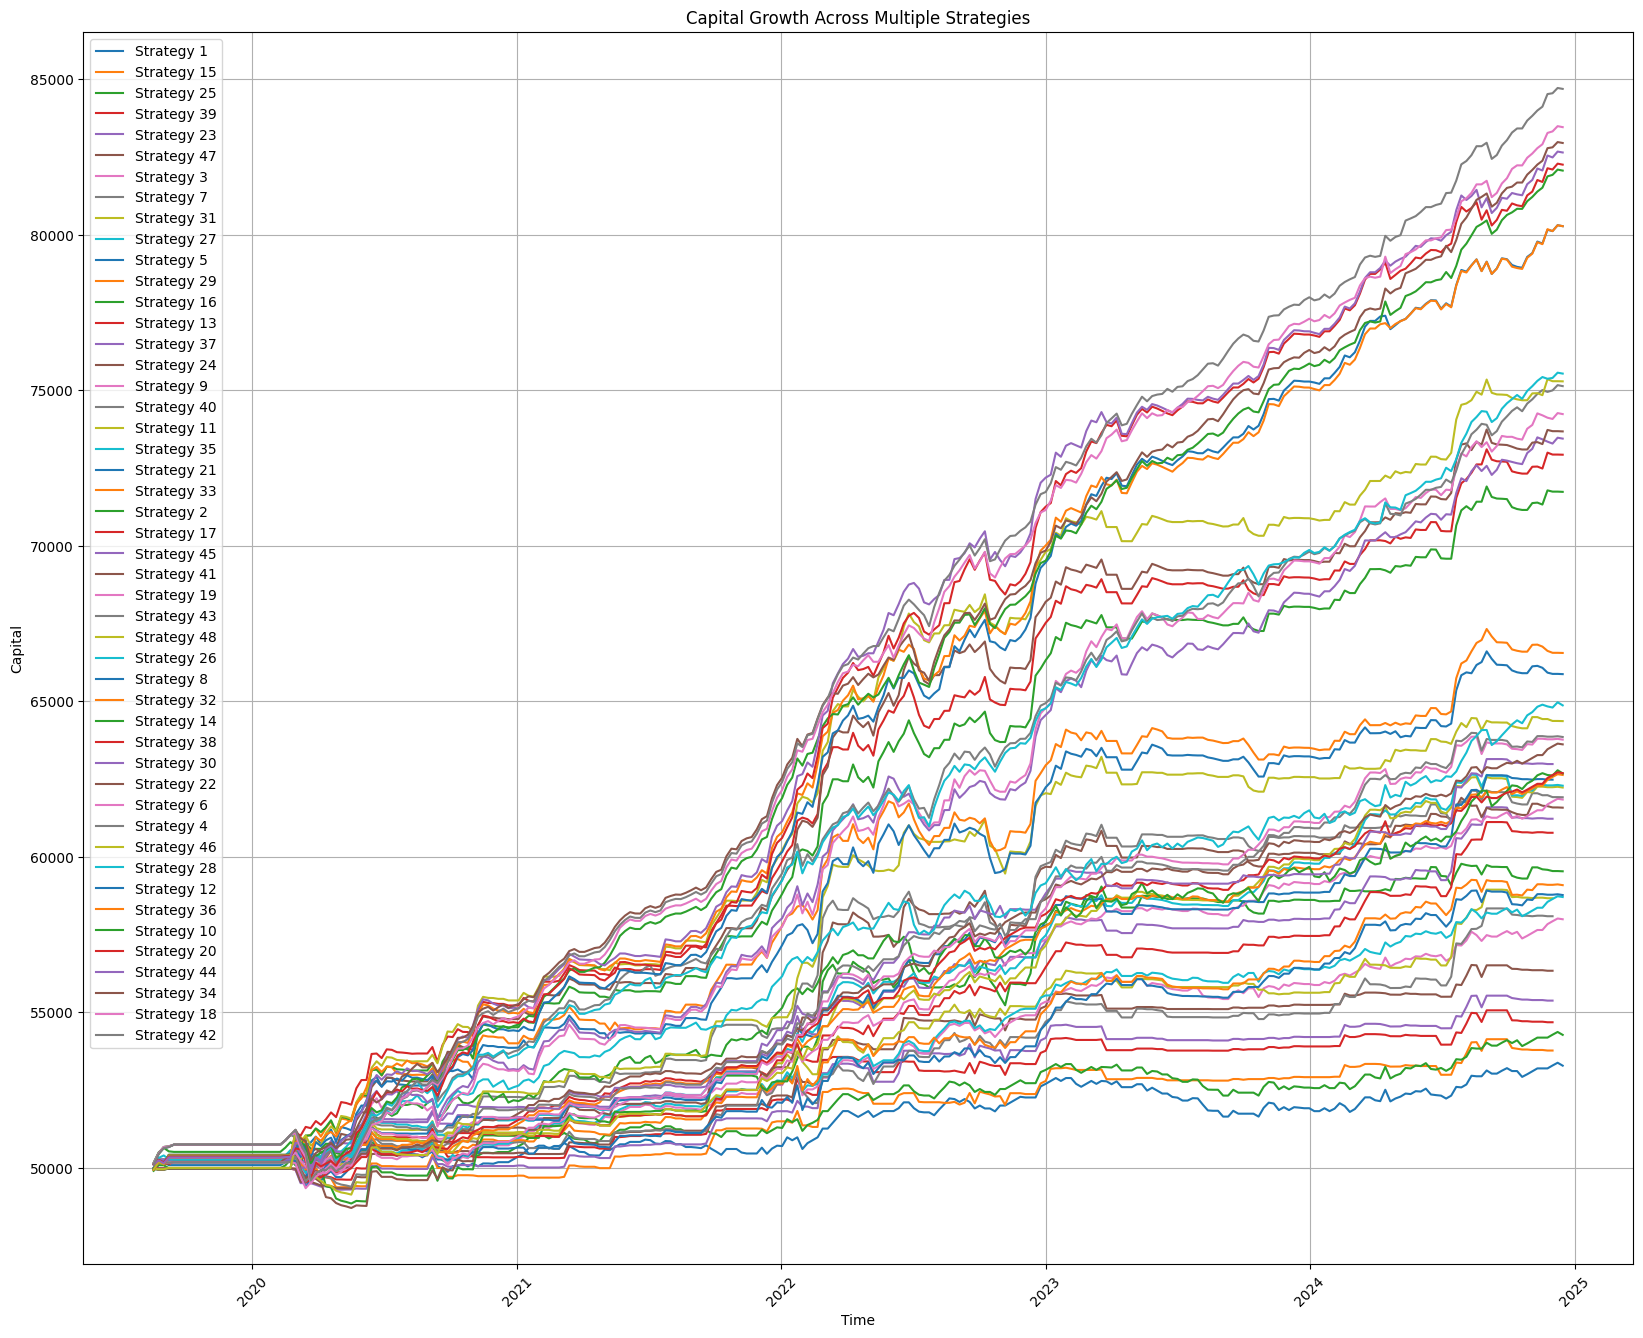

In [39]:
import matplotlib.pyplot as plt
trades_database = load_object('trade_datas/basicEntries_3UT_levels_breakeven=0_StrategyStop1&2.pkl')
# selected_ids = [8,14]
selected_ids = winrate_dictionnary.keys()

plt.figure(figsize=(20, 16))

for id in selected_ids:
    df_temp =  trades_database[id][0]

    # Définir 'datetime' comme index pour pouvoir utiliser resample
    df_temp.set_index('entry_date', inplace=True)

    # Resampler les données par semaine (par exemple, la somme des profits par semaine)
    df_temp = df_temp.resample('W').agg({'profit_from_start(%)': ['sum']})

    capital = 50_000
    l = []
    for profit in df_temp['profit_from_start(%)']["sum"]:
        capital += 50_000 * profit/ 100
        l.append(capital)

    plt.plot(df_temp.index, l, label=f"Strategy {id}")  # Use a label for each plot for better identification

    del df_temp

# Add labels and title
plt.xlabel("Time")
plt.ylabel("Capital")
plt.xticks(rotation=45)
plt.title("Capital Growth Across Multiple Strategies")
plt.legend()  # Show legend for all plots
plt.grid(True)
plt.show()

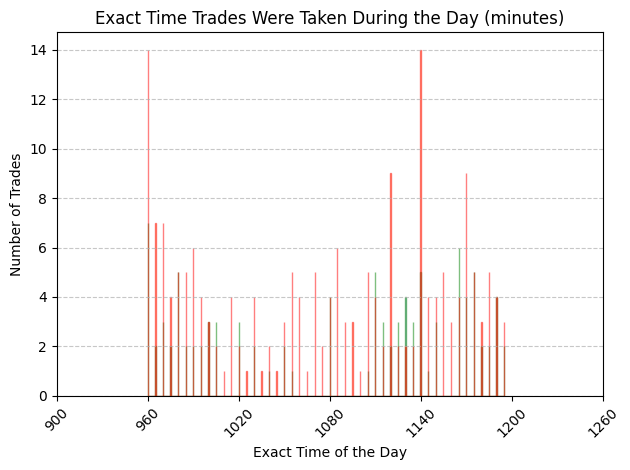

In [14]:
import matplotlib.pyplot as plt

id = 7
df, _, _, _ = trades_database[id]

df_hist_w = df[df['profit_from_start(%)']>0]['entry_date'].apply(lambda x: x.hour*60 + x.minute)
df_hist_l = df[df['profit_from_start(%)']<0]['entry_date'].apply(lambda x: x.hour*60 + x.minute)

# Plot the histogram
plt.hist(df_hist_w, bins=1440, edgecolor='green', alpha=0.5)
plt.hist(df_hist_l, bins=1440, edgecolor='red', alpha=0.5)

plt.xlabel('Exact Time of the Day')
plt.ylabel('Number of Trades')
plt.title('Exact Time Trades Were Taken During the Day (minutes)')
plt.xticks(range(900, 1320, 60), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Ensures labels fit inside the plot
plt.show()

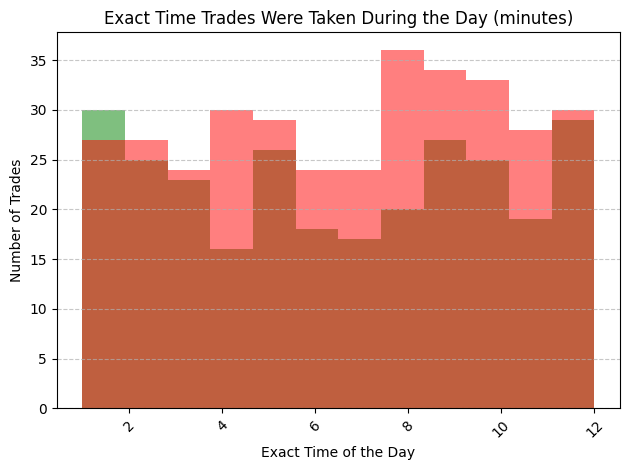

In [5]:
import matplotlib.pyplot as plt

id = 18
df, _, _, _ = trades_database[id]

df_hist_w = df[df['profit_from_start(%)']>0]['entry_date'].dt.month
df_hist_l = df[df['profit_from_start(%)']<0]['entry_date'].dt.month
months = ['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août', 'septembre', 'octobre', 'novembre', 'décembre']
# Plot the histogram
plt.hist(df_hist_w, bins=12, color='green', alpha=0.5)
plt.hist(df_hist_l, bins=12, color='red', alpha=0.5)

plt.xlabel('Exact Time of the Day')
plt.ylabel('Number of Trades')
plt.title('Exact Time Trades Were Taken During the Day (minutes)')
plt.xticks(rotation=45, )#ticks=range(1, 13), labels=months)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Ensures labels fit inside the plot
plt.show()

choses à faire pour continuer à backtest :
- avoir le temps moyen d'un trade avec la stratégie DTP
- regarder si le type de position (short ou long) a un impact sur le winrate
- continuer à améliorer la stratégie avec:
    - les autres conditions d'entrées de la strat DTP (ex: taille de la bougie)
    - des conditions sur les niveaux pivot
    - des conditions pour savoir si on est en range
    - faire en sorte que le tp/sl s'adapte à la distance au pivot
- calculer le profit réel en $
- stop loss suiveur : passe en breakeven sous certaines conditions